# Example 2 &ndash; Average of steady states #

In this example, we reproduce figure 4 of the paper *The determining role of covariances in large networks of stochastic neurons*. For details on PopNet's functions, see the [documentation](https://vincentpainchaud.github.io/PopNet/) of the package.

In [1]:
import popnet as pn
import matplotlib.pyplot as plt
plt.ioff()

We start by defining a configuration with all parameters used in this example. For the code to run faster, we will run fewer stochastic simulations than in the paper (only 100).

In [2]:
config = pn.default_config('1A', scale='micro')
config.resize_network(100)
pop = config.network.populations[0]

pop.set_means(alpha=4.2, beta=.05, gamma=1, theta=12.7)
pop.set_scales(theta=.2)
config.network.c = 17
config.network.reset_parameters()

config.initial_state = .71, .221
config.set_covariances_from_expectations()
config.final_time = 200
config.delta = .2
config.executions = 100

Now, we integrate numerically the second-order system with PopNet's methods.

In [3]:
integrator = pn.get_integrator(config, 'extended')
integrator.run('ode')
solution = integrator.output()
integrator.close()

We also run stochastic simulations and compute statistics.

In [4]:
simulator = pn.get_simulator(config, act='step', mode='chain')
simulator.run(initial_state='random', verbose=True)
stats = simulator.output()
simulator.close()

100%|█████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


Then, we define a Matplotlib figure on which we will draw the results.

In [5]:
def get_handles_labels_with_row_titles(ax, titles):
    nrow = len(titles)
    empty_plots = nrow * [ax.plot([], [], marker='', ls='')[0]]
    handles, labels = ax.get_legend_handles_labels()
    row_len = len(handles) // nrow
    new_handles = empty_plots + handles
    new_labels = titles + labels
    return new_handles, new_labels

def remove_row_title_handles(legend):
    vpack = legend._legend_handle_box.get_children()[0]
    for hpack in vpack.get_children():
        drawing_area = hpack.get_children()[0]
        drawing_area.set_width(-4)

preamble = ('\\usepackage{lmodern}'
            '\\usepackage{amssymb}'
            '\\usepackage{sansmath}'
            '\\sansmath')
cm = 1 / 2.54 #in/cm

fs = 8
hpad = .4
hlen = 1.4

fig, axes = pn.figure(subplots=((2,3,(1,2)), (2,3,(4,5)), (2,3,(3,6))), figsize=(18*cm, 5*cm),
                      font_family='sans-serif', usetex=True, preamble=preamble, tight_layout=False)
fig.subplots_adjust(left=.03, right=.985, bottom=.15, top=.98, wspace=.25, hspace=.1)

solution.fig = stats.fig = fig

On the first subfigure, we plot the expectations of the fractions of the network in each of the three states that we obtained from the dynamical system's solution as well as the corresponding averages obtained from stochastic simulations.

In [6]:
stats.ax = axes[0]
solution.ax = axes[0]

for X in ('A', 'R', 'S'):
    solution.plot[X](ls='dotted')
    stats.plot[X](color=stats.colors[f'C{X}{X}'][0][0])
solution.setup(set_xlabel=False, fontsize=fs)
solution.ax.set_xticklabels([])
solution.ax.tick_params(labelsize=fs)
titles = ['Solution', 'Statistics']
handles, labels = get_handles_labels_with_row_titles(solution.ax, titles)
legend = solution.ax.legend(handles[::2], labels[::2], fontsize=fs, ncol=4, handletextpad=hpad,
                            handlelength=hlen, loc='upper right')
remove_row_title_handles(legend)
solution.ax.add_artist(legend)
legend = solution.ax.legend(handles[1::2], labels[1::2], fontsize=fs, ncol=4, handletextpad=hpad,
                            handlelength=hlen, loc='lower right')
remove_row_title_handles(legend)

On the second subfigure, we plot the variances from the solution and the sample variances from the stochastic simulations.

In [7]:
stats.ax = axes[1]
solution.ax = axes[1]

for X in ('A', 'R', 'S'):
    solution.plot[f'C{X}{X}'](ls='dotted', color=solution.colors[X][0], zorder=2.5)
    stats.plot[f'C{X}{X}']()
solution.setup(units='$1/\\gamma$', ylim='unbounded', fontsize=fs, labelpad=2)
solution.ax.tick_params(labelsize=fs)
titles = ['Solution', 'Statistics']
handles, labels = get_handles_labels_with_row_titles(solution.ax, titles)
legend = solution.ax.legend(handles, labels, fontsize=fs, ncol=4, handletextpad=hpad,
                            handlelength=hlen, loc='lower right', bbox_to_anchor=(1, .05))
remove_row_title_handles(legend)

On the third subfigure, we plot a phase plane of the mean-field system, on which we draw its solution as well as a single trajectory of the Markov chain.

In [8]:
plane = pn.get_system(config, 'mean-field').get_phase_plane((0,1))

plane.fig = fig
plane.ax = axes[-1]
xlim = (-.04, 1)
ylim = (-.01, .26)

plane.streamplot((100, 100), xlim=xlim, ylim=ylim, color='black', linewidth=.6, arrowsize=.5, density=1.25)
plane.plot_nullclines(lw=1.5)
plane.plot_solution(label='Mean-field', lw=1.5)
plane.plot_trajectory(label='Trajectories', lw=.8)
plane.config.reset_micro_initial_state()
plane.plot_trajectory(cut=.05, label=None, color='C3', lw=.75)
plane.setup(xlim=xlim, ylim=ylim, fontsize=fs, xlabel_kwargs={'labelpad': 2},
            ylabel_kwargs={'va': 'center'})
plane.legend(lw=1.5, fontsize=fs, loc='upper left', bbox_to_anchor=(.05, 1),
             handletextpad=hpad, handlelength=hlen)
plane.ax.tick_params(labelsize=fs)

Finally, we draw the figure. Of course, since we performed less simulations and the results are random, the figure will be slightly different from that shown in the paper.

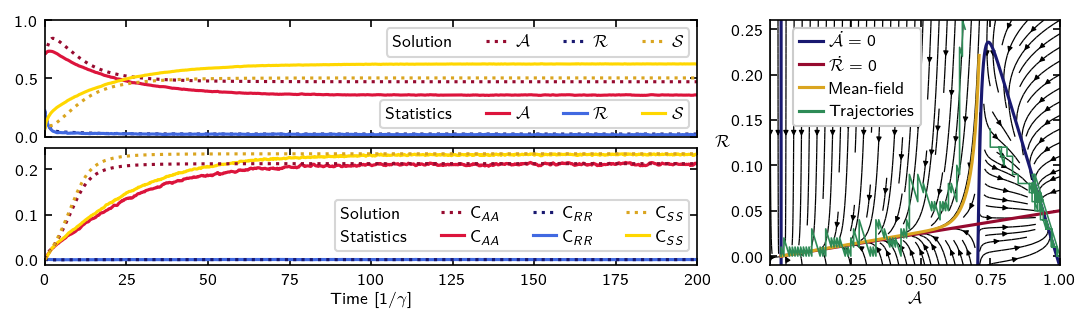

In [9]:
pn.draw()